AIPI 590 - XAI | Assignment #05

This assignment performed an ResNet34 model application to CIFAR-10, and a LIME heatmap plot for indication of positive contribution regions.

Haodong He

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Haodong12/AIPI-590/blob/main/assignment%20%2305/assignment%20%2305.ipynb)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install numpy==1.25.2 pandas==2.0.3 matplotlib==3.7.1 scikit-learn==1.2.2 xgboost==1.7.5 --quiet
!pip install pyarrow==8.0.0 transformers==4.31.0 datasets==2.13.0 torch==2.0.1 lime==0.2.0.1 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 7.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.0.3 which is incompatible.
mizani 0.11.4 requires pandas>=2.1.0, but you have pandas 2.0.3 which is incompatible.
plotnine 0.13.6 requires pandas<3.0.0,>=2.1.0, but you have pandas 2.0.3 which is incompatible.
xarray 2024.9.0 requires pandas>=2.1, but you have pandas 2.0.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 62.4 MB/s

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from transformers import BertTokenizer, BertForSequenceClassification
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
# Define the transformation to apply to the images
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Download and load the CIFAR-10 training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

# Check the dataset size
print(f"Number of training samples: {len(trainset)}")
print(f"Number of testing samples: {len(testset)}")


100%|██████████| 170498071/170498071 [00:10<00:00, 16074135.27it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
Number of training samples: 50000
Number of testing samples: 10000


In [ ]:
# Load ResNet34 model pre-trained on ImageNet
model = models.resnet34(pretrained=True)

# Modify the final layer to output 10 classes (for CIFAR-10)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# Define the loss function (cross-entropy loss) and optimizer (Adam or SGD)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 166MB/s]


In [ ]:
print(torch.cuda.is_available())


True


In [ ]:
print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Check if model is on GPU
print(next(model.parameters()).device)

cuda:0


In [ ]:
# Training loop
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch [{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

Epoch [1, 100] loss: 1.772
Epoch [1, 200] loss: 1.833
Epoch [1, 300] loss: 1.881
Epoch [1, 400] loss: 1.793
Epoch [1, 500] loss: 1.714
Epoch [1, 600] loss: 1.746
Epoch [1, 700] loss: 1.606
Epoch [1, 800] loss: 1.675
Epoch [1, 900] loss: 1.668
Epoch [1, 1000] loss: 1.683
Epoch [1, 1100] loss: 1.587
Epoch [1, 1200] loss: 1.616
Epoch [1, 1300] loss: 1.587
Epoch [1, 1400] loss: 1.576
Epoch [1, 1500] loss: 1.585
Epoch [1, 1600] loss: 1.540
Epoch [1, 1700] loss: 1.499
Epoch [1, 1800] loss: 1.610
Epoch [1, 1900] loss: 1.613
Epoch [1, 2000] loss: 1.586
Epoch [1, 2100] loss: 1.746
Epoch [1, 2200] loss: 1.847
Epoch [1, 2300] loss: 1.742
Epoch [1, 2400] loss: 1.703
Epoch [1, 2500] loss: 1.672
Epoch [1, 2600] loss: 1.655
Epoch [1, 2700] loss: 1.608
Epoch [1, 2800] loss: 1.514
Epoch [1, 2900] loss: 1.760
Epoch [1, 3000] loss: 1.647
Epoch [1, 3100] loss: 1.626
Epoch [1, 3200] loss: 1.662
Epoch [1, 3300] loss: 1.593
Epoch [1, 3400] loss: 1.629
Epoch [1, 3500] loss: 1.571
Epoch [1, 3600] loss: 1.599
E

In [ ]:
# Evaluation loop
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 10000 test images: 76.18%


  0%|          | 0/1000 [00:00<?, ?it/s]

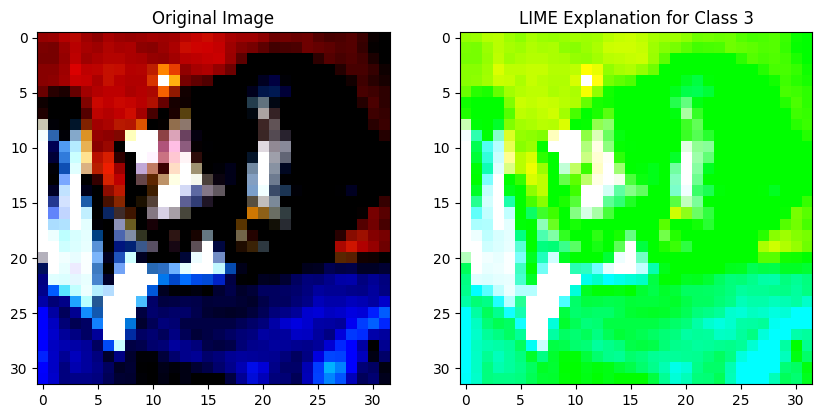

Predicted class: 3, Probability: 0.9587082266807556


In [ ]:
# Set model to evaluation mode
model.eval()

# Define a function to convert a tensor image into a format LIME expects (numpy array)
def tensor_to_numpy_img(tensor_img):
    img = tensor_img.cpu().clone().detach().numpy()
    img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    return img

# Define a function to predict probabilities for LIME
def predict_proba(images):
    # Convert the images back to PyTorch tensors and get model predictions
    tensor_imgs = [transforms.ToTensor()(img) for img in images]
    tensor_imgs = torch.stack(tensor_imgs).to(device)
    outputs = model(tensor_imgs)
    return F.softmax(outputs, dim=1).cpu().detach().numpy()

# Select a single image from the test dataset to explain
data_iter = iter(testloader)
images, labels = next(data_iter)
single_image = images[0].to(device)  # Use only the first image and add a batch dimension
single_image_np = tensor_to_numpy_img(single_image)

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation for the single image
explanation = explainer.explain_instance(single_image_np, predict_proba, top_labels=5, hide_color=0, num_samples=1000)

# Get explanation for the top predicted class
predicted_class = model(single_image.unsqueeze(0)).argmax(dim=1).item()
temp, mask = explanation.get_image_and_mask(predicted_class, positive_only=False, num_features=10, hide_rest=False)

# Show the explanation
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(single_image_np)
ax[0].set_title('Original Image')
ax[1].imshow(mark_boundaries(temp, mask))
ax[1].set_title(f'LIME Explanation for Class {predicted_class}')
plt.show()

# Print out the predicted class and probability for confirmation
probs = torch.nn.functional.softmax(model(single_image.unsqueeze(0)), dim=1)
print(f"Predicted class: {predicted_class}, Probability: {probs[0][predicted_class].item()}")

**Interpretation:**

**Orginal Image(Left):**

This image is from the dataset and was past through the model. The model predicted **class 3** wiith a probability of **95.87%**.

**LIME Explanation(Right):**

The plot shows the important regions of the image contributed to the model's decision to classify the image as Cat. **Green areas** are regions where LIME believes the model looked at when making prediction, these area are positively contributed to the model's prediction. **Blue areas** are negatively contributed to the model decision, as they are less indicative. **White areas:** These regions are neutral and had little to no impact on the prediction.

In [ ]:
# Used chatgpt for guidance of imaging generating